In [1]:
#now we have our CSV file

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

matches = pd.read_csv("data/matches.csv", index_col=0)

In [2]:
matches.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
0,2022-08-13,21:00,La Liga,Matchweek 1,Sat,Home,D,0.0,0.0,Rayo Vallecano,...,Match Report,NaN,21.0,5.0,17.0,1.0,0,0,2023,Barcelona
1,2022-08-21,22:00,La Liga,Matchweek 2,Sun,Away,W,4.0,1.0,Real Sociedad,...,Match Report,NaN,15.0,7.0,14.6,0.0,0,0,2023,Barcelona
2,2022-08-28,19:30,La Liga,Matchweek 3,Sun,Home,W,4.0,0.0,Valladolid,...,Match Report,NaN,24.0,9.0,14.4,1.0,0,0,2023,Barcelona
3,2022-09-03,21:00,La Liga,Matchweek 4,Sat,Away,W,3.0,0.0,Sevilla,...,Match Report,NaN,18.0,5.0,16.0,2.0,0,0,2023,Barcelona
5,2022-09-10,18:30,La Liga,Matchweek 5,Sat,Away,W,4.0,0.0,Cádiz,...,Match Report,NaN,16.0,8.0,14.9,0.0,0,0,2023,Barcelona


### Exploratory Data Analysis

In [3]:
print(matches.shape)
#in La Liga there are 20 teams and each plays 38 matches and we have pulled 2 seasons
print(38 *20 *2)

(1282, 27)
1520


In [4]:
#however there are 1280 matches.
#2023 season has 26 matches played per team as at the time of scraping this data ie (12 *20) rows will be missing
# 1280 + 240 = 1520
12* 20

240

In [5]:
matches['team'].value_counts()

Mallorca           65
Osasuna            65
Barcelona          64
Valencia           64
Espanyol           64
Cadiz              64
Sevilla            64
Getafe             64
Real Madrid        64
Celta Vigo         64
Elche              64
Rayo Vallecano     64
Athletic Club      64
Villarreal         64
Real Betis         64
Real Sociedad      64
Atletico Madrid    64
Levante            38
Granada            38
Alaves             38
Almeria            26
Valladolid         26
Girona             26
Name: team, dtype: int64

Three teams are relegated each year and three teams enter. We'll expect 6 teams to have fewer matches. From data we can tell Levante, Granada and Alaves were relegated from the 2022 season hence are not in the 2023 season. New clubs who replaced them were Almeria, Valladolid and Girona.

In [6]:
matches['round'].value_counts()
# The 'round' column tells us which match week the match was played. We'll expect 20 matches per match week times 2 seasons so 40 total each week.
# we want to know how many matches were played each week.
# Any match week after 26 will have less than 40 as the current season is at matchweek 26

Matchweek 1     40
Matchweek 15    40
Matchweek 26    40
Matchweek 25    40
Matchweek 24    40
Matchweek 23    40
Matchweek 22    40
Matchweek 21    40
Matchweek 2     40
Matchweek 17    40
Matchweek 19    40
Matchweek 18    40
Matchweek 16    40
Matchweek 20    40
Matchweek 14    40
Matchweek 13    40
Matchweek 12    40
Matchweek 11    40
Matchweek 10    40
Matchweek 9     40
Matchweek 8     40
Matchweek 7     40
Matchweek 6     40
Matchweek 5     40
Matchweek 4     40
Matchweek 3     40
Matchweek 27    22
Matchweek 28    20
Matchweek 29    20
Matchweek 30    20
Matchweek 31    20
Matchweek 32    20
Matchweek 33    20
Matchweek 34    20
Matchweek 35    20
Matchweek 36    20
Matchweek 37    20
Matchweek 38    20
Name: round, dtype: int64

In [7]:
matches.dtypes 

date             object
time             object
comp             object
round            object
day              object
venue            object
result           object
gf              float64
ga              float64
opponent         object
xg              float64
xga             float64
poss            float64
attendance      float64
captain          object
formation        object
referee          object
match report     object
notes           float64
sh              float64
sot             float64
dist            float64
fk              float64
pk                int64
pkatt             int64
season            int64
team             object
dtype: object

In [8]:
# convert date to datetime
matches["date"] = pd.to_datetime(matches["date"])
matches['venue_code'] = matches['venue'].astype("category").cat.codes #from strings to categories and from categories to numbers.
#converting opponent to codes so each team ie opponent has a unique code instead of string
matches["opp_code"] = matches["opponent"].astype("category").cat.codes
# certain teams play better at certain times of day maybe. we can utilize the time col
matches["hour"] = matches["time"].str.replace(":.+", "", regex=True).astype("int")
matches['day_code'] = matches["date"].dt.dayofweek
matches['target'] = matches["result"].astype("category").cat.codes 

In [9]:
#let's get a target variable
matches["result"].unique()


array(['D', 'W', 'L'], dtype=object)

In [10]:
matches['target'].unique()     
# WIN = 2 | D = 0| L=1

array([0, 2, 1], dtype=int8)

In [11]:
matches.dtypes

date            datetime64[ns]
time                    object
comp                    object
round                   object
day                     object
venue                   object
result                  object
gf                     float64
ga                     float64
opponent                object
xg                     float64
xga                    float64
poss                   float64
attendance             float64
captain                 object
formation               object
referee                 object
match report            object
notes                  float64
sh                     float64
sot                    float64
dist                   float64
fk                     float64
pk                       int64
pkatt                    int64
season                   int64
team                    object
venue_code                int8
opp_code                  int8
hour                     int32
day_code                 int64
target                    int8
dtype: o

In [12]:
matches.describe().T

,count,mean,std,min,25%,50%,75%,max
gf,1282.0,1.234789,1.168253,0.0,0.0,1.0,2.0,6.0
ga,1282.0,1.234789,1.168253,0.0,0.0,1.0,2.0,6.0
xg,1282.0,1.233697,0.776813,0.0,0.6,1.1,1.7,4.9
xga,1282.0,1.233697,0.776813,0.0,0.6,1.1,1.7,4.9
poss,1282.0,50.000000,11.279156,18.0,42.0,50.0,58.0,82.0
attendance,1282.0,25511.288612,17535.432520,583.0,12975.0,18183.0,36502.0,95745.0
notes,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sh,1282.0,11.773791,4.690116,0.0,8.0,11.0,15.0,36.0
sot,1282.0,3.803432,2.271306,0.0,2.0,3.0,5.0,16.0
dist,1281.0,18.377830,3.339203,9.1,16.1,18.3,20.2,36.2


Text(0.5, 1.0, 'Match Outcomes Overview')

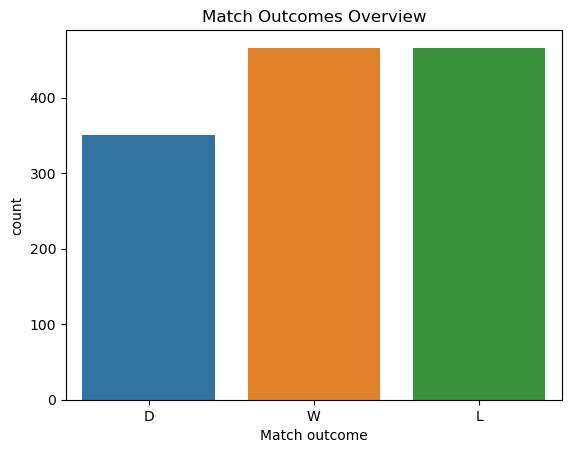

In [13]:
sns.countplot(x=matches['result'])
plt.xlabel('Match outcome')
plt.title("Match Outcomes Overview")

it appears there are the same number of wins as well as loses in the dataset about 480 each whiles Draw outcomes was about 350. 


In [14]:
matches['day_code'].unique()

array([5, 6, 3, 1, 2, 0, 4], dtype=int64)

Text(0.5, 1.0, 'Match Frequencies based on days of the week')

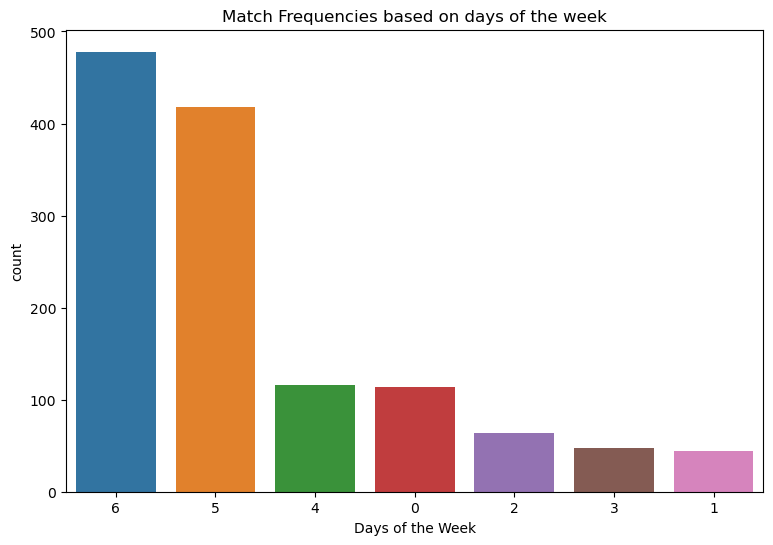

In [15]:
plt.figure(figsize=(9,6))
sns.countplot(matches, x='day_code', order=matches["day_code"].value_counts().index)
#plt.xticks(np.arange(7), ['Monday', "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.xlabel("Days of the Week")
plt.title("Match Frequencies based on days of the week")

It appears a lot of matches were played on Sunday and Saturday. <br>
 let's see the distribution of goals over the two seasons using the rug plot 

Text(0.5, 1.0, 'Distribution of goals')

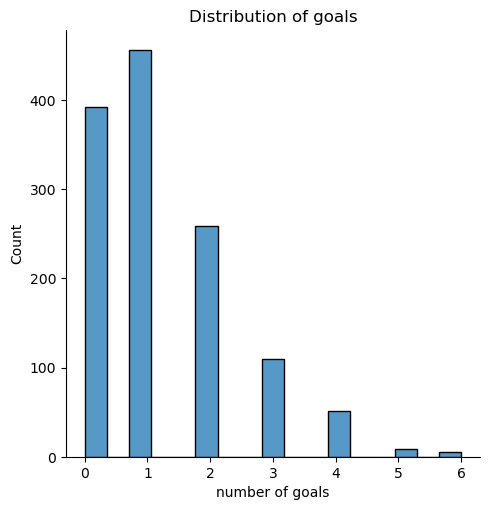

In [16]:
sns.displot(x='gf', data=matches)
plt.xlabel('number of goals')
plt.title('Distribution of goals')


It looks like most matches ends up with single goals followed by no goals at all. Rarely does six goals occur in a match. <br>
It appears this league doesn't produce a lot of goals.

### The Models

In [17]:
# 2022 will be my training dataset and 2023 will be my test dataset.  This is a time series dataset
rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=101)
train = matches[matches['date'] < '2023-01-01']
test = matches[matches['date'] > '2023-01-01']

In [18]:
predictors = ["venue_code", 'opp_code', 'hour', 'day_code']
rf.fit(train[predictors], train['target'])       

RandomForestClassifier(min_samples_split=10, n_estimators=50, random_state=101)

In [19]:
#predictions
y_pred = rf.predict(test[predictors])
acc = accuracy_score(test['target'], y_pred)
acc

0.47297297297297297

In [20]:
print(classification_report(test['target'], y_pred))



              precision    recall  f1-score   support

           0       0.33      0.19      0.24        52
           1       0.48      0.56      0.52        85
           2       0.52      0.55      0.53        85

    accuracy                           0.47       222
   macro avg       0.44      0.44      0.43       222
weighted avg       0.46      0.47      0.46       222



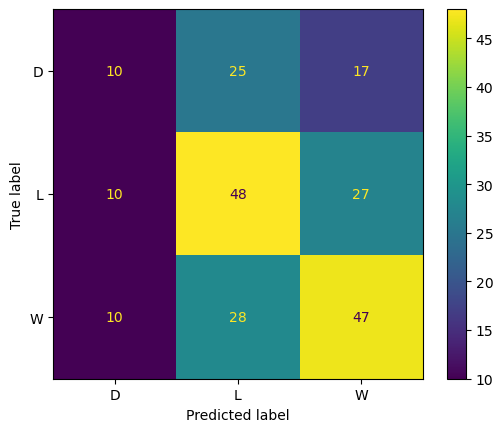

In [21]:
cm = confusion_matrix(test['target'], y_pred)
labels = ['D', 'L', 'W']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()

The model didn't perform so well. <br>
When we predicted a win, how often did the team actually win. <br>
Let's find precision score for the entire dataset. <br>

In [22]:
from sklearn.metrics import precision_score
precision_score(test['target'], y_pred, average='weighted', zero_division='warn')

0.4577949181909578

### Model 2

We want rolling average for team performance. we can use the outcome of previous n games to help predict the outcome of a current game. <br>
It kinda take into consideration the current Form of the team. eg if they have lost their last 5 games, we expect them to lose the current game.

In [23]:
grouped_matches = matches.groupby('team')
group = grouped_matches.get_group('Barcelona')
group # all matches by Barcelona


,date,time,comp,round,day,venue,result,gf,ga,opponent,...,fk,pk,pkatt,season,team,venue_code,opp_code,hour,day_code,target
0,2022-08-13,21:00,La Liga,Matchweek 1,Sat,Home,D,0.0,0.0,Rayo Vallecano,...,1.0,0,0,2023,Barcelona,1,16,21,5,0
1,2022-08-21,22:00,La Liga,Matchweek 2,Sun,Away,W,4.0,1.0,Real Sociedad,...,0.0,0,0,2023,Barcelona,0,18,22,6,2
2,2022-08-28,19:30,La Liga,Matchweek 3,Sun,Home,W,4.0,0.0,Valladolid,...,1.0,0,0,2023,Barcelona,1,21,19,6,2
3,2022-09-03,21:00,La Liga,Matchweek 4,Sat,Away,W,3.0,0.0,Sevilla,...,2.0,0,0,2023,Barcelona,0,19,21,5,2
5,2022-09-10,18:30,La Liga,Matchweek 5,Sat,Away,W,4.0,0.0,Cádiz,...,0.0,0,0,2023,Barcelona,0,7,18,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48,2022-05-01,21:00,La Liga,Matchweek 34,Sun,Home,W,2.0,1.0,Mallorca,...,1.0,0,0,2022,Barcelona,1,14,21,6,2
49,2022-05-07,21:00,La Liga,Matchweek 35,Sat,Away,W,2.0,1.0,Betis,...,0.0,0,0,2022,Barcelona,0,5,21,5,2
50,2022-05-10,21:30,La Liga,Matchweek 36,Tue,Home,W,3.0,1.0,Celta Vigo,...,1.0,0,0,2022,Barcelona,1,6,21,1,2
51,2022-05-15,19:30,La Liga,Matchweek 37,Sun,Away,D,0.0,0.0,Getafe,...,1.0,0,0,2022,Barcelona,0,10,19,6,0


In [24]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("date")
    rolling_stats = group[cols].rolling(3, closed='left').mean() #take the current week out and ignore when creating the rolling averages
    group[new_cols] = rolling_stats      
    group = group.dropna(subset=new_cols) #drop missing values. pandas fills missing weeks with 0 in cases when we can't go back three matches.
    return group

In [25]:
cols = ['gf', 'ga', 'sh', 'sot', 'dist', 'fk', 'pk', 'pkatt']
new_cols = [f"{c}_rolling" for c in cols] # cols with the moving averages in them

In [26]:
new_cols 

['gf_rolling',
 'ga_rolling',
 'sh_rolling',
 'sot_rolling',
 'dist_rolling',
 'fk_rolling',
 'pk_rolling',
 'pkatt_rolling']

In [27]:
rolling_averages(group, cols, new_cols)

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,day_code,target,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling
4,2021-09-20,21:00,La Liga,Matchweek 5,Mon,Home,D,1.0,1.0,Granada,...,0,0,2.333333,1.333333,9.666667,4.666667,14.900000,0.333333,0.000000,0.000000
5,2021-09-23,22:00,La Liga,Matchweek 6,Thu,Away,D,0.0,0.0,Cádiz,...,3,0,1.333333,1.000000,11.000000,4.000000,15.600000,0.666667,0.000000,0.000000
6,2021-09-26,16:15,La Liga,Matchweek 7,Sun,Home,W,3.0,0.0,Levante,...,6,2,1.000000,0.666667,10.000000,3.666667,16.066667,0.666667,0.000000,0.000000
8,2021-10-02,21:00,La Liga,Matchweek 8,Sat,Away,L,0.0,2.0,Atlético Madrid,...,5,1,1.333333,0.333333,14.000000,6.333333,16.633333,0.666667,0.333333,0.333333
9,2021-10-17,21:00,La Liga,Matchweek 9,Sun,Home,W,3.0,1.0,Valencia,...,6,2,1.000000,0.666667,11.333333,5.000000,18.733333,1.000000,0.333333,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,2023-02-19,21:00,La Liga,Matchweek 22,Sun,Home,W,2.0,0.0,Cádiz,...,6,2,2.000000,0.333333,11.666667,4.666667,13.766667,0.666667,0.000000,0.000000
35,2023-02-26,18:30,La Liga,Matchweek 23,Sun,Away,L,0.0,1.0,Almería,...,6,1,2.000000,0.000000,12.666667,5.000000,13.466667,0.333333,0.000000,0.000000
37,2023-03-05,16:15,La Liga,Matchweek 24,Sun,Home,W,1.0,0.0,Valencia,...,6,2,1.000000,0.333333,11.666667,3.000000,12.733333,0.000000,0.000000,0.000000
38,2023-03-12,21:00,La Liga,Matchweek 25,Sun,Away,W,1.0,0.0,Athletic Club,...,6,2,1.000000,0.333333,13.666667,3.000000,15.566667,0.666667,0.000000,0.333333


In [28]:
#applying to all our matches.
matches_rolling = matches.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols))
matches_rolling

date   time     comp         round  day venue result   gf  \
team                                                                            
Alaves     3  2021-09-18  21:00  La Liga   Matchweek 5  Sat  Home      L  0.0   
           4  2021-09-22  19:30  La Liga   Matchweek 6  Wed  Away      L  0.0   
           5  2021-09-25  14:00  La Liga   Matchweek 7  Sat  Home      W  1.0   
           6  2021-10-01  21:00  La Liga   Matchweek 8  Fri  Away      L  0.0   
           7  2021-10-18  19:00  La Liga   Matchweek 9  Mon  Home      L  0.0   
...                  ...    ...      ...           ...  ...   ...    ...  ...   
Villarreal 33 2023-02-18  18:30  La Liga  Matchweek 22  Sat  Away      L  2.0   
           34 2023-02-27  21:00  La Liga  Matchweek 23  Mon  Home      W  2.0   
           35 2023-03-04  16:15  La Liga  Matchweek 24  Sat  Away      W  2.0   
           37 2023-03-12  18:30  La Liga  Matchweek 25  Sun  Home      D  1.0   
           39 2023-03-19  16:15  La Liga  Matchweek 26  Sun  Away      W  3.0   

                ga         opponent  ...  day_code  target  gf_rolling  \
team                                 ...                                 
Alaves     3   2.0          Osasuna  ...         5       1    0.333333   
           4   1.0         Espanyol  ...         2       1    0.000000   
           5   0.0  Atlético Madrid  ...         5       2    0.000000   
           6   1.0    Athletic Club  ...         4       1    0.333333   
           7   1.0            Betis  ...         0       1    0.333333   
...            ...              ...  ...       ...     ...         ...   
Villarreal 33  4.0         Mallorca  ...         5       1    0.333333   
           34  1.0           Getafe  ...         0       2    1.000000   
           35  0.0          Almería  ...         5       2    1.333333   
           37  1.0            Betis  ...         6       0    2.000000   
           39  0.0          Osasuna  ...         6       2    1.666667   

               ga_rolling sh_rolling sot_rolling dist_rolling fk_rolling  \
team                                                                       
Alaves     3     2.666667   9.333333    3.000000    17.766667   0.666667   
           4     2.000000   8.666667    3.000000    18.866667   0.333333   
           5     2.000000   8.000000    2.333333    18.900000   0.333333   
           6     1.000000   7.333333    2.000000    17.833333   0.000000   
           7     0.666667  10.333333    2.666667    15.100000   0.000000   
...                   ...        ...         ...          ...        ...   
Villarreal 33    1.666667  12.333333    2.333333    17.900000   0.333333   
           34    2.666667  11.000000    2.666667    17.933333   0.000000   
           35    2.000000  10.000000    3.666667    17.800000   0.333333   
           37    1.666667  12.000000    5.000000    16.966667   0.333333   
           39    0.666667  14.333333    5.000000    16.000000   0.666667   

               pk_rolling  pkatt_rolling  
team                                      
Alaves     3     0.333333       0.333333  
           4     0.000000       0.000000  
           5     0.000000       0.000000  
           6     0.000000       0.000000  
           7     0.000000       0.000000  
...                   ...            ...  
Villarreal 33    0.000000       0.000000  
           34    0.000000       0.000000  
           35    0.000000       0.000000  
           37    0.000000       0.000000  
           39    0.000000       0.000000  

[1210 rows x 40 columns]

In [29]:
# we don't need that outer level index
matches_rolling = matches_rolling.droplevel("team")
matches_rolling

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,day_code,target,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling
3,2021-09-18,21:00,La Liga,Matchweek 5,Sat,Home,L,0.0,2.0,Osasuna,...,5,1,0.333333,2.666667,9.333333,3.000000,17.766667,0.666667,0.333333,0.333333
4,2021-09-22,19:30,La Liga,Matchweek 6,Wed,Away,L,0.0,1.0,Espanyol,...,2,1,0.000000,2.000000,8.666667,3.000000,18.866667,0.333333,0.000000,0.000000
5,2021-09-25,14:00,La Liga,Matchweek 7,Sat,Home,W,1.0,0.0,Atlético Madrid,...,5,2,0.000000,2.000000,8.000000,2.333333,18.900000,0.333333,0.000000,0.000000
6,2021-10-01,21:00,La Liga,Matchweek 8,Fri,Away,L,0.0,1.0,Athletic Club,...,4,1,0.333333,1.000000,7.333333,2.000000,17.833333,0.000000,0.000000,0.000000
7,2021-10-18,19:00,La Liga,Matchweek 9,Mon,Home,L,0.0,1.0,Betis,...,0,1,0.333333,0.666667,10.333333,2.666667,15.100000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,2023-02-18,18:30,La Liga,Matchweek 22,Sat,Away,L,2.0,4.0,Mallorca,...,5,1,0.333333,1.666667,12.333333,2.333333,17.900000,0.333333,0.000000,0.000000
34,2023-02-27,21:00,La Liga,Matchweek 23,Mon,Home,W,2.0,1.0,Getafe,...,0,2,1.000000,2.666667,11.000000,2.666667,17.933333,0.000000,0.000000,0.000000
35,2023-03-04,16:15,La Liga,Matchweek 24,Sat,Away,W,2.0,0.0,Almería,...,5,2,1.333333,2.000000,10.000000,3.666667,17.800000,0.333333,0.000000,0.000000
37,2023-03-12,18:30,La Liga,Matchweek 25,Sun,Home,D,1.0,1.0,Betis,...,6,0,2.000000,1.666667,12.000000,5.000000,16.966667,0.333333,0.000000,0.000000


In [30]:
# we have 1208 rows but our index doesn't go that high meaning a lot of the rows or values are duplicated. we don't need that. Only unique values in index.
# let's assign unique values.
matches_rolling.index = range(matches_rolling.shape[0])
matches_rolling

,date,time,comp,round,day,venue,result,gf,ga,opponent,...,day_code,target,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling
0,2021-09-18,21:00,La Liga,Matchweek 5,Sat,Home,L,0.0,2.0,Osasuna,...,5,1,0.333333,2.666667,9.333333,3.000000,17.766667,0.666667,0.333333,0.333333
1,2021-09-22,19:30,La Liga,Matchweek 6,Wed,Away,L,0.0,1.0,Espanyol,...,2,1,0.000000,2.000000,8.666667,3.000000,18.866667,0.333333,0.000000,0.000000
2,2021-09-25,14:00,La Liga,Matchweek 7,Sat,Home,W,1.0,0.0,Atlético Madrid,...,5,2,0.000000,2.000000,8.000000,2.333333,18.900000,0.333333,0.000000,0.000000
3,2021-10-01,21:00,La Liga,Matchweek 8,Fri,Away,L,0.0,1.0,Athletic Club,...,4,1,0.333333,1.000000,7.333333,2.000000,17.833333,0.000000,0.000000,0.000000
4,2021-10-18,19:00,La Liga,Matchweek 9,Mon,Home,L,0.0,1.0,Betis,...,0,1,0.333333,0.666667,10.333333,2.666667,15.100000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1205,2023-02-18,18:30,La Liga,Matchweek 22,Sat,Away,L,2.0,4.0,Mallorca,...,5,1,0.333333,1.666667,12.333333,2.333333,17.900000,0.333333,0.000000,0.000000
1206,2023-02-27,21:00,La Liga,Matchweek 23,Mon,Home,W,2.0,1.0,Getafe,...,0,2,1.000000,2.666667,11.000000,2.666667,17.933333,0.000000,0.000000,0.000000
1207,2023-03-04,16:15,La Liga,Matchweek 24,Sat,Away,W,2.0,0.0,Almería,...,5,2,1.333333,2.000000,10.000000,3.666667,17.800000,0.333333,0.000000,0.000000
1208,2023-03-12,18:30,La Liga,Matchweek 25,Sun,Home,D,1.0,1.0,Betis,...,6,0,2.000000,1.666667,12.000000,5.000000,16.966667,0.333333,0.000000,0.000000


In [31]:
def make_predictions(data, predictors):
    train = data[data["date"] < "2023-01-01"]
    test = data[data['date'] > "2023-01-01"]
    rf.fit(train[predictors], train["target"])
    y_pred = rf.predict(test[predictors])
    report = print(classification_report(test['target'], y_pred))
    combined  = pd.DataFrame(dict(actual=test['target'], predicted=y_pred), index=test.index)
    return report, combined    

In [32]:
report, combined = make_predictions(matches_rolling, predictors + new_cols)

              precision    recall  f1-score   support

           0       0.16      0.08      0.10        52
           1       0.48      0.53      0.50        85
           2       0.41      0.49      0.45        85

    accuracy                           0.41       222
   macro avg       0.35      0.37      0.35       222
weighted avg       0.38      0.41      0.39       222



In [33]:
combined

,actual,predicted
47,1,1
48,0,1
49,0,2
50,2,2
51,1,2
...,...,...
1205,1,1
1206,2,2
1207,2,1
1208,0,1


In [34]:
combined = combined.merge(matches_rolling[["date", "team", "opponent", "result"]], left_index=True, right_index=True)
combined

,actual,predicted,date,team,opponent,result
47,1,1,2023-01-08,Almeria,Real Sociedad,L
48,0,1,2023-01-15,Almeria,Atlético Madrid,D
49,0,2,2023-01-23,Almeria,Valencia,D
50,2,2,2023-01-27,Almeria,Espanyol,W
51,1,2,2023-02-06,Almeria,Rayo Vallecano,L
...,...,...,...,...,...,...
1205,1,1,2023-02-18,Villarreal,Mallorca,L
1206,2,2,2023-02-27,Villarreal,Getafe,W
1207,2,1,2023-03-04,Villarreal,Almería,W
1208,0,1,2023-03-12,Villarreal,Betis,D


In [35]:
# The algo did at predicting both sides of the match .we have data for home and away for each match. the algo could have made different predictions for each side of that eg 
# might predict away will win and home will also win.

matches['team'].unique()

array(['Barcelona', 'Real Madrid', 'Atletico Madrid', 'Real Sociedad',
       'Real Betis', 'Villarreal', 'Athletic Club', 'Rayo Vallecano',
       'Osasuna', 'Celta Vigo', 'Mallorca', 'Girona', 'Getafe', 'Sevilla',
       'Cadiz', 'Valladolid', 'Espanyol', 'Valencia', 'Almeria', 'Elche',
       'Granada', 'Levante', 'Alaves'], dtype=object)

In [36]:
matches['opponent'].unique()

array(['Rayo Vallecano', 'Real Sociedad', 'Valladolid', 'Sevilla',
       'Cádiz', 'Elche', 'Mallorca', 'Celta Vigo', 'Real Madrid',
       'Villarreal', 'Athletic Club', 'Valencia', 'Almería', 'Osasuna',
       'Espanyol', 'Atlético Madrid', 'Getafe', 'Girona', 'Betis',
       'Barcelona', 'Alavés', 'Levante', 'Granada'], dtype=object)

In [37]:
#real betis == betis

class MissingDict(dict):
    __missing__ = lambda self, key: key

map_values = {
    "Real Betis" : "Betis"
}

mapping = MissingDict(**map_values)

In [38]:
matches.columns

Index(['date', 'time', 'comp', 'round', 'day', 'venue', 'result', 'gf', 'ga',
       'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain', 'formation',
       'referee', 'match report', 'notes', 'sh', 'sot', 'dist', 'fk', 'pk',
       'pkatt', 'season', 'team', 'venue_code', 'opp_code', 'hour', 'day_code',
       'target'],
      dtype='object')

In [39]:
combined['new_team'] = combined['team'].map(mapping)

In [40]:
combined

,actual,predicted,date,team,opponent,result,new_team
47,1,1,2023-01-08,Almeria,Real Sociedad,L,Almeria
48,0,1,2023-01-15,Almeria,Atlético Madrid,D,Almeria
49,0,2,2023-01-23,Almeria,Valencia,D,Almeria
50,2,2,2023-01-27,Almeria,Espanyol,W,Almeria
51,1,2,2023-02-06,Almeria,Rayo Vallecano,L,Almeria
...,...,...,...,...,...,...,...
1205,1,1,2023-02-18,Villarreal,Mallorca,L,Villarreal
1206,2,2,2023-02-27,Villarreal,Getafe,W,Villarreal
1207,2,1,2023-03-04,Villarreal,Almería,W,Villarreal
1208,0,1,2023-03-12,Villarreal,Betis,D,Villarreal


In [41]:
#we're merging the dataframe with itself. so that we can cross check, cos say barcelona vrs real madrid will also have real madrid vrs barcelona
# we want to see if the predictions match up
merged = combined.merge(combined, left_on=["date", "new_team"], right_on=["date", "opponent"])

In [42]:
merged

,actual_x,predicted_x,date,team_x,opponent_x,result_x,new_team_x,actual_y,predicted_y,team_y,opponent_y,result_y,new_team_y
0,0,2,2023-01-09,Athletic Club,Osasuna,D,Athletic Club,0,1,Osasuna,Athletic Club,D,Osasuna
1,1,2,2023-01-14,Athletic Club,Real Sociedad,L,Athletic Club,2,2,Real Sociedad,Athletic Club,W,Real Sociedad
2,1,1,2023-01-22,Athletic Club,Real Madrid,L,Athletic Club,2,1,Real Madrid,Athletic Club,W,Real Madrid
3,1,1,2023-01-29,Athletic Club,Celta Vigo,L,Athletic Club,2,0,Celta Vigo,Athletic Club,W,Celta Vigo
4,2,2,2023-02-03,Athletic Club,Cádiz,W,Athletic Club,1,1,Cadiz,Athletic Club,L,Cadiz
...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,1,1,2023-02-18,Villarreal,Mallorca,L,Villarreal,2,0,Mallorca,Villarreal,W,Mallorca
185,2,2,2023-02-27,Villarreal,Getafe,W,Villarreal,1,1,Getafe,Villarreal,L,Getafe
186,2,1,2023-03-04,Villarreal,Almería,W,Villarreal,1,2,Almeria,Villarreal,L,Almeria
187,0,1,2023-03-12,Villarreal,Betis,D,Villarreal,0,2,Real Betis,Villarreal,D,Betis


In [43]:
#merged[(merged["predicted_x"] == 1) & (merged['predicted_y'] == 0)]['actual_x'].value_counts()

In [44]:
# you could scrap a lot more data
# use more columns to generate predictions. who the referee was who the captain was
#use neural networks
# use other competitions. ie did they compete outside their league etc